# Berkeley Housing Pipeline - Permitting, Construction, Economic and Neighborhood Outcomes 
- January 4, 2026

## [Measuring Actual Outcomes of new housing policies](https://www.eatingpolicy.com/p/outcomes-reviews-realigning-legislative?utm_campaign=post)

This **Master Analysis Notebook** will be refined into a set of Jupyter Notebooks with independent notebooks for each step: data acquisition and cleaning; statistical analysis; visualization and mapping; report generation. 

## This set of computational notebooks should complement and extend the [City of Berkeley's Annual Housing Element Progress Report](https://berkeleyca.gov/sites/default/files/documents/2025-03-28%20%20%20Housing%20Element%20and%20General%20Plan%20Annual%20Progress%20Reports.pdf) to the State of California HCD


### This is built as a template that may be cloned from Github, then completely modified and run locally on your machine, or at Google Colab.

For Berkeley High classes, UC Berkeley classes, or Berkeleyside, Berkeley Scanner, Daily Cal or other data journalism sites, the SQL data repositories may be used with Datasette. Claude can generate SQL queries to be used interactively with Datasette to create interactive maps, statistical analyses, and a wide variety of time series analyses.

As the City of Berkeley builds better API interfaces to the City Open.Gov databases of permits for Planning, Building, Design Review, and Certificates of Occupancy, the richness of analysis will improve.  We will add all Berkeley Business Licenses, all publicly available energy and water use data, and displacement and affordabiity analyses. 

We will analyze actual outcomes of Berkeley and State of California policies, laws, and regulations. 
for Berkeley businesses and residences


This is a complete workflow from data → analysis → visualization → database
- started Jan 3 - Sat- 10:27 am
- Jan 4 - 2:24

## Setup

In [1]:
# Monday 5 Jan
# 🌐 ENVIRONMENT SETUP (Auto-detects Colab vs Local)
import sys
import os

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print('🌐 Running in Google Colab')
    
    # Download data from GitHub
    import urllib.request
    
    print('   Downloading data from GitHub...')
    data_url = 'https://raw.githubusercontent.com/blockXblock/berkeley-housing-analysis/main/housing_projects_final_complete.csv'
    urllib.request.urlretrieve(data_url, 'housing_projects_final_complete.csv')
    print('   ✅ Data downloaded!')
    
    # Set working directory
    data_dir = '/content'
    outputs_dir = '/content/outputs'
    
    # Create outputs directory
    os.makedirs(outputs_dir, exist_ok=True)
    
else:
    print('💻 Running locally')
    
    # Detect if in Binder (check for jovyan user) or local
    if os.path.exists('/home/jovyan'):
        # Binder environment - go up one level from notebooks/
        data_dir = '/home/jovyan'
        print('   Environment: Binder')
        
        # Change to parent directory to access data
        if os.getcwd() == '/home/jovyan/notebooks':
            os.chdir('/home/jovyan')
            print('   Changed to /home/jovyan')
    else:
        # Local Jupyter
        data_dir = '/Users/johngage/berkeley-data'
        print('   Environment: Local Jupyter')
    
    outputs_dir = f'{data_dir}/outputs'
    os.makedirs(outputs_dir, exist_ok=True)

print(f'   Data directory: {data_dir}')
print(f'   Outputs directory: {outputs_dir}')
print(f'   Current directory: {os.getcwd()}')

# Verify data file exists
data_file = f'{data_dir}/housing_projects_final_complete.csv'
if os.path.exists(data_file):
    print(f'   ✅ Data file found: {data_file}')
else:
    print(f'   ❌ Data file NOT found: {data_file}')
    print(f'   Files in {data_dir}:')
    print(f'   {os.listdir(data_dir)}')

print('\n' + '='*70)

💻 Running locally
   Environment: Local Jupyter
   Data directory: /Users/johngage/berkeley-data
   Outputs directory: /Users/johngage/berkeley-data/outputs
   Current directory: /Users/johngage/berkeley-data/notebooks
   ✅ Data file found: /Users/johngage/berkeley-data/housing_projects_final_complete.csv



In [2]:
# CELL: Setup for Google Colab (auto-detects, won't run in local Jupyter)

import sys
import os

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    print("🌐 Running in Google Colab - downloading data from GitHub...")
    
    # Download the data file from GitHub
    import urllib.request
    
    data_url = "https://raw.githubusercontent.com/blockXblock/berkeley-housing-analysis/main/housing_projects_final_complete.csv"
    
    urllib.request.urlretrieve(data_url, "housing_projects_final_complete.csv")
    
    print("✅ Data downloaded!")
    
    # Set data directory for Colab
    data_dir = "/content"
else:
    print("💻 Running locally")
    data_dir = data_dir

💻 Running locally


In [3]:
import pandas as pd
import sqlite3
import folium
from datetime import datetime
import os

print('✅ Imports successful')
print(f'Working directory: {os.getcwd()}')

✅ Imports successful
Working directory: /Users/johngage/berkeley-data/notebooks


## 🔄 DATA REFRESH (Optional)

**Choose your approach:**
- **Level 1:** Quick refresh using existing data *(recommended, 30 seconds)*
- **Level 2:** Complete rebuild from Berkeley Open Data API *(advanced, 5-10 minutes)*

Skip to **Section 1** if you want to use existing data as-is.

### Level 1: Quick Data Refresh

Check if data files exist and are recent. Optionally re-geocode any missing addresses.

In [4]:
# LEVEL 1: Quick refresh
import pandas as pd
import os
from datetime import datetime

data_dir = data_dir

# Check data files
print('📊 DATA FILE STATUS:')
print('='*70)

files_to_check = [
    'housing_projects_final_complete.csv',
    'alameda_lookup_complete.csv',
    'berkeley_addresses_with_fields.csv'
]

for filename in files_to_check:
    filepath = f'{data_dir}/{filename}'
    if os.path.exists(filepath):
        stat = os.stat(filepath)
        size_mb = stat.st_size / (1024 * 1024)
        modified = datetime.fromtimestamp(stat.st_mtime)
        days_old = (datetime.now() - modified).days
        
        print(f'\n✅ {filename}')
        print(f'   Size: {size_mb:.1f} MB')
        print(f'   Modified: {modified.strftime("%Y-%m-%d")} ({days_old} days ago)')
    else:
        print(f'\n❌ {filename} - NOT FOUND')
        print(f'   → Need to run Level 2: Complete Rebuild')

# Load and check projects
projects_file = f'{data_dir}/housing_projects_final_complete.csv'
if os.path.exists(projects_file):
    df = pd.read_csv(projects_file)
    geocoded = df['latitude'].notna().sum()
    total = len(df)
    
    print(f'\n📈 PROJECTS DATA:')
    print(f'   Total projects: {total}')
    print(f'   Geocoded: {geocoded} ({geocoded/total*100:.1f}%)')
    print(f'   Missing coordinates: {total - geocoded}')
    
    if geocoded < total:
        print(f'\n⚠️  {total - geocoded} addresses need geocoding')
        print(f'   Run geocoding cell below to fill gaps')
    else:
        print(f'\n✅ All projects geocoded! Data is ready to use.')
else:
    print(f'\n❌ Projects file not found. Run Level 2: Complete Rebuild.')

print('\n' + '='*70)

📊 DATA FILE STATUS:

✅ housing_projects_final_complete.csv
   Size: 0.0 MB
   Modified: 2025-12-20 (16 days ago)

✅ alameda_lookup_complete.csv
   Size: 59.1 MB
   Modified: 2025-12-19 (17 days ago)

✅ berkeley_addresses_with_fields.csv
   Size: 13.0 MB
   Modified: 2025-12-20 (16 days ago)

📈 PROJECTS DATA:
   Total projects: 84
   Geocoded: 84 (100.0%)
   Missing coordinates: 0

✅ All projects geocoded! Data is ready to use.



---

### Level 2: Complete Data Rebuild (Advanced)

⚠️ **Warning:** This fetches fresh data from Berkeley Open Data Portal and rebuilds everything from scratch.

**Time:** 5-10 minutes  
**Requires:** Internet connection, Berkeley Open Data API access

**Instructions:** Uncomment cells below to activate the rebuild process.

In [5]:
# LEVEL 2 - STEP 1: Fetch Berkeley Open Data
# Uncomment the code below to run

print('(Level 2 cells are commented out by default)')
print('Uncomment to activate data rebuild from Berkeley Open Data Portal')

# Placeholder - add Berkeley API code here after finding dataset ID

(Level 2 cells are commented out by default)
Uncomment to activate data rebuild from Berkeley Open Data Portal


---

## ✅ Data Refresh Complete

Proceed to **Section 1: Load Data** below.

## 1. Load Data

Using existing geocoded projects (84 projects, 100% geocoded)

In [6]:
# Load projects (path relative to notebooks directory)
data_dir = data_dir
df = pd.read_csv(f'{data_dir}/housing_projects_final_complete.csv')

print(f'📊 Loaded: {len(df)} projects')
print(f'   With coordinates: {df["latitude"].notna().sum()}')
print(f'   Total units: {df["net_units"].sum():,.0f}')
print(f'   Date range: {df["year"].min():.0f} - {df["year"].max():.0f}')

# Show sample
df.head()

📊 Loaded: 84 projects
   With coordinates: 84
   Total units: 5,283
   Date range: 2020 - 2025


,id,address_display,apn,owner,net_units,new_units,old_units,year,permits,description,status,latitude,longitude,num_permits,project_size_category,slug
0,1,1750 SACRAMENTO St,058 214901904,NaN,739.0,739.0,0.0,2024.0,PLN2024-0010,AB 2011 Ministerial Application. The proposed ...,Under Review,37.874312,-122.282959,1,Mega (100+),1750-sacramento-st
1,2,2276 SHATTUCK Ave,057 202800400,NaN,336.0,336.0,0.0,2024.0,ZP2024-0067,SB330 Preliminary Application: Retaining of th...,In Review,37.867738,-122.268240,1,Mega (100+),2276-shattuck-ave
2,3,2700 SHATTUCK Ave,054 172300100,NaN,276.0,276.0,0.0,2024.0,ZP2024-0058,SB330 project to demolish an existing commerci...,Corrections Pending Applicant,37.859780,-122.267828,1,Mega (100+),2700-shattuck-ave
3,4,1914 FIFTH St,057 210000702,NaN,257.0,257.0,0.0,2020.0,ZP2020-0104,demolish an existing parking lot and portions ...,Under Review,37.868230,-122.299296,1,Mega (100+),1914-fifth-st
4,5,2425 DURANT Ave,055 187800701,NaN,250.0,250.0,19.0,2024.0,"ZP2024-0162, PLN2024-0049",SB-330 PROJECT - Demolition of all existing bu...,Pending Final Action,37.867951,-122.260142,2,Mega (100+),2425-durant-ave


## 2. Summary Statistics

In [7]:
print('📈 SUMMARY STATISTICS')
print('='*70)

# Overall stats
print(f"\nTotal projects: {len(df)}")
print(f"Total units: {df['net_units'].sum():,.0f}")
print(f"Average units per project: {df['net_units'].mean():.1f}")
print(f"Median units per project: {df['net_units'].median():.0f}")
print(f"Largest project: {df['net_units'].max():.0f} units at {df.loc[df['net_units'].idxmax(), 'address_display']}")

# Projects by year
print('\n📅 PROJECTS BY YEAR:')
by_year = df.groupby('year').agg({
    'net_units': ['sum', 'count'],
    'address_display': 'first'
})
by_year.columns = ['total_units', 'num_projects', '_']
by_year = by_year[['num_projects', 'total_units']]
print(by_year.to_string())

# Projects by size category
print('\n📏 PROJECTS BY SIZE:')
size_bins = [0, 20, 50, 100, 200, 1000]
size_labels = ['Small (<20)', 'Small-Medium (20-49)', 'Medium (50-99)', 'Large (100-199)', 'Very Large (200+)']
df['size_category'] = pd.cut(df['net_units'], bins=size_bins, labels=size_labels)
by_size = df.groupby('size_category', observed=True).agg({
    'net_units': ['count', 'sum']
})
by_size.columns = ['num_projects', 'total_units']
print(by_size.to_string())

📈 SUMMARY STATISTICS

Total projects: 84
Total units: 5,283
Average units per project: 62.9
Median units per project: 10
Largest project: 739 units at 1750 SACRAMENTO St

📅 PROJECTS BY YEAR:
        num_projects  total_units
year                             
2020.0             2        258.0
2021.0             3         70.0
2022.0             8        782.0
2023.0             7        388.0
2024.0            32       3420.0
2025.0            32        365.0

📏 PROJECTS BY SIZE:
                      num_projects  total_units
size_category                                  
Small (<20)                     42        173.0
Small-Medium (20-49)             6        213.0
Medium (50-99)                  15       1059.0
Large (100-199)                  8       1085.0
Very Large (200+)                9       2754.0


## 3. Geographic Analysis

In [8]:
# Top streets by development
print('🏘️ TOP STREETS BY HOUSING UNITS:')
print('='*70)

# Extract street name from address
df['street'] = df['address_display'].str.split().str[1:].str.join(' ')

top_streets = df.groupby('street').agg({
    'net_units': 'sum',
    'address_display': 'count'
}).rename(columns={'address_display': 'num_projects'}).sort_values('net_units', ascending=False)

print('\nTop 20 streets:')
print(top_streets.head(20).to_string())

# Geographic distribution
print('\n📍 GEOGRAPHIC COORDINATES:')
print(f"  Latitude range: {df['latitude'].min():.6f} to {df['latitude'].max():.6f}")
print(f"  Longitude range: {df['longitude'].min():.6f} to {df['longitude'].max():.6f}")
print(f"  All coordinates within Berkeley bounds: {((df['latitude'] >= 37.84) & (df['latitude'] <= 37.91) & (df['longitude'] >= -122.32) & (df['longitude'] <= -122.23)).all()}")

🏘️ TOP STREETS BY HOUSING UNITS:

Top 20 streets:
                net_units  num_projects
street                                 
SHATTUCK Ave       1564.0            10
SACRAMENTO St       742.0             2
DURANT Ave          453.0             4
UNIVERSITY Ave      452.0             6
SAN PABLO Ave       437.0             5
FIFTH St            272.0             5
OXFORD St           212.0             1
KITTREDGE St        211.0             2
BANCROFT Way        200.0             3
TELEGRAPH Ave       156.0             3
VIRGINIA St         131.0             1
MILVIA St           113.0             2
LE CONTE Ave         65.0             1
ELLSWORTH St         63.0             1
CENTER St            58.0             1
BERKELEY Sq          50.0             1
DWIGHT Way           31.0             3
COLLEGE Ave           7.0             2
SIXTH St              7.0             2
CEDAR St              6.0             1

📍 GEOGRAPHIC COORDINATES:
  Latitude range: 37.851354 to 37.900125
  

## 4. Interactive Map

In [9]:
print('🗺️ Creating interactive map... with iframe')

# Create base map
m = folium.Map(
    location=[37.8715, -122.2730],
    zoom_start=13,
    tiles='OpenStreetMap'
)

# Color by project size
def get_color(units):
    if units >= 200:
        return 'red'
    elif units >= 100:
        return 'orange'
    elif units >= 50:
        return 'blue'
    elif units >= 20:
        return 'green'
    else:
        return 'lightblue'

# Add markers for all geocoded projects
for idx, row in df[df['latitude'].notna()].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"<b>{row['address_display']}</b><br>Units: {row['net_units']}<br>Year: {row['year']:.0f}<br>Status: {row.get('status', 'N/A')}",
        color=get_color(row['net_units']),
        fill=True,
        fillColor=get_color(row['net_units']),
        fillOpacity=0.7
    ).add_to(m)

# Save map to outputs directory
os.makedirs(outputs_dir, exist_ok=True)
map_path = f'{outputs_dir}/berkeley_housing_map.html'
m.save(map_path)
print(f'✅ Map saved to: {map_path}')

# Display map
from IPython.display import display
display(m)


🗺️ Creating interactive map... with iframe
✅ Map saved to: /Users/johngage/berkeley-data/outputs/berkeley_housing_map.html


## 5. Database Export

In [10]:
print('💾 Creating SQLite database...')

# Database path
db_path = f'{data_dir}/berkeley_housing_analysis.db'

# Create database
conn = sqlite3.connect(db_path)

# Export projects table
df.to_sql('projects', conn, if_exists='replace', index=False)

# Create indexes
cursor = conn.cursor()
cursor.execute('CREATE INDEX IF NOT EXISTS idx_year ON projects(year)')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_units ON projects(net_units)')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_coords ON projects(latitude, longitude)')
conn.commit()

print(f'✅ Database created: {db_path}')

# Test queries
print('\n📊 Testing database queries:')

# Total units by year
query1 = pd.read_sql('''
    SELECT 
        year,
        COUNT(*) as projects,
        SUM(net_units) as total_units
    FROM projects
    GROUP BY year
    ORDER BY year DESC
''', conn)

print('\nUnits by year:')
print(query1.to_string(index=False))

# Largest projects
query2 = pd.read_sql('''
    SELECT 
        address_display,
        net_units,
        year
    FROM projects
    ORDER BY net_units DESC
    LIMIT 10
''', conn)

print('\nTop 10 largest projects:')
print(query2.to_string(index=False))

conn.close()
print('\n✅ Database ready for use')

💾 Creating SQLite database...
✅ Database created: /Users/johngage/berkeley-data/berkeley_housing_analysis.db

📊 Testing database queries:

Units by year:
  year  projects  total_units
2025.0        32        365.0
2024.0        32       3420.0
2023.0         7        388.0
2022.0         8        782.0
2021.0         3         70.0
2020.0         2        258.0

Top 10 largest projects:
    address_display  net_units   year
 1750 SACRAMENTO St      739.0 2024.0
  2276 SHATTUCK Ave      336.0 2024.0
  2700 SHATTUCK Ave      276.0 2024.0
      1914 FIFTH St      257.0 2020.0
    2425 DURANT Ave      250.0 2024.0
2029 UNIVERSITY Ave      240.0 2024.0
 2601 SAN PABLO Ave      223.0 2022.0
  2920 SHATTUCK Ave      221.0 2022.0
     1899 OXFORD St      212.0 2024.0
  3000 SHATTUCK Ave      166.0 2022.0

✅ Database ready for use


## 5. Additional Analysis and Visualizations

Deep dive into trends, patterns, and development velocity.

In [11]:
# Additional Analysis - Query 1: Annual Trends

print('📈 ANNUAL TRENDS ANALYSIS')
print('='*70)

# Projects and units by year
annual_stats = df.groupby('year').agg({
    'address_display': 'count',
    'net_units': ['sum', 'mean', 'median']
}).round(1)

annual_stats.columns = ['Projects', 'Total_Units', 'Avg_Units', 'Median_Units']

print('\nProjects and Units by Year:')
print(annual_stats.to_string())

# Calculate year-over-year growth
annual_stats['Unit_Growth_Rate'] = annual_stats['Total_Units'].pct_change() * 100
annual_stats['Project_Growth_Rate'] = annual_stats['Projects'].pct_change() * 100

print('\nYear-over-Year Growth Rates:')
print(annual_stats[['Unit_Growth_Rate', 'Project_Growth_Rate']].to_string())

print('\n' + '='*70)


📈 ANNUAL TRENDS ANALYSIS

Projects and Units by Year:
        Projects  Total_Units  Avg_Units  Median_Units
year                                                  
2020.0         2        258.0      129.0         129.0
2021.0         3         70.0       23.3          16.0
2022.0         8        782.0       97.8          79.5
2023.0         7        388.0       55.4          54.0
2024.0        32       3420.0      106.9          67.5
2025.0        32        365.0       11.4           3.0

Year-over-Year Growth Rates:
        Unit_Growth_Rate  Project_Growth_Rate
year                                         
2020.0               NaN                  NaN
2021.0        -72.868217            50.000000
2022.0       1017.142857           166.666667
2023.0        -50.383632           -12.500000
2024.0        781.443299           357.142857
2025.0        -89.327485             0.000000



In [12]:
# Additional Analysis - Query 2: Size Distribution Over Time

print('📏 PROJECT SIZE TRENDS')
print('='*70)

# Projects by size category and year
size_by_year = df.groupby(['year', 'size_category'], observed=True)['net_units'].agg(['count', 'sum'])
size_by_year.columns = ['num_projects', 'total_units']

print('\nProjects by Size Category and Year:')
print(size_by_year.to_string())

# Percentage of units by size category per year
pct_by_size = df.groupby(['year', 'size_category'], observed=True)['net_units'].sum().unstack(fill_value=0)
pct_by_size_pct = pct_by_size.div(pct_by_size.sum(axis=1), axis=0) * 100

print('\nPercentage of Units by Size Category (% of total units per year):')
print(pct_by_size_pct.round(1).to_string())

print('\n' + '='*70)


📏 PROJECT SIZE TRENDS

Projects by Size Category and Year:
                             num_projects  total_units
year   size_category                                  
2020.0 Small (<20)                      1          1.0
       Very Large (200+)                1        257.0
2021.0 Small (<20)                      2         20.0
       Small-Medium (20-49)             1         50.0
2022.0 Small (<20)                      3         13.0
       Small-Medium (20-49)             1         27.0
       Large (100-199)                  2        298.0
       Very Large (200+)                2        444.0
2023.0 Small (<20)                      1         17.0
       Small-Medium (20-49)             2         69.0
       Medium (50-99)                   3        197.0
       Large (100-199)                  1        105.0
2024.0 Small (<20)                     10         43.0
       Small-Medium (20-49)             1         31.0
       Medium (50-99)                   8        611.0
      

In [13]:
# Additional Analysis - Query 3: Geographic Concentration

print('🗺️ GEOGRAPHIC CONCENTRATION')
print('='*70)

# Top corridors/streets by units
street_analysis = df.groupby('street').agg({
    'net_units': 'sum',
    'address_display': 'count'
}).rename(columns={'address_display': 'num_projects'}).sort_values('net_units', ascending=False)

print('\nTop 20 Streets by Total Units:')
print(street_analysis.head(20).to_string())

# Concentration metrics
total_units = df['net_units'].sum()
top_10_units = street_analysis.head(10)['net_units'].sum()
concentration_pct = (top_10_units / total_units) * 100

print(f'\n📊 Concentration Metrics:')
print(f'   Top 10 streets contain: {top_10_units:,.0f} units ({concentration_pct:.1f}% of total)')
print(f'   Average units per street: {street_analysis["net_units"].mean():.1f}')
print(f'   Median units per street: {street_analysis["net_units"].median():.1f}')

print('\n' + '='*70)


🗺️ GEOGRAPHIC CONCENTRATION

Top 20 Streets by Total Units:
                net_units  num_projects
street                                 
SHATTUCK Ave       1564.0            10
SACRAMENTO St       742.0             2
DURANT Ave          453.0             4
UNIVERSITY Ave      452.0             6
SAN PABLO Ave       437.0             5
FIFTH St            272.0             5
OXFORD St           212.0             1
KITTREDGE St        211.0             2
BANCROFT Way        200.0             3
TELEGRAPH Ave       156.0             3
VIRGINIA St         131.0             1
MILVIA St           113.0             2
LE CONTE Ave         65.0             1
ELLSWORTH St         63.0             1
CENTER St            58.0             1
BERKELEY Sq          50.0             1
DWIGHT Way           31.0             3
COLLEGE Ave           7.0             2
SIXTH St              7.0             2
CEDAR St              6.0             1

📊 Concentration Metrics:
   Top 10 streets contain: 4,699 u

In [14]:
# Additional Analysis - Query 4: Completion Timeline

print('⏱️ PROJECT TIMELINE ANALYSIS')
print('='*70)

# Projects by current status (if status column exists)
if 'status' in df.columns:
    status_summary = df.groupby('status').agg({
        'net_units': ['count', 'sum'],
        'address_display': 'first'
    })
    status_summary.columns = ['num_projects', 'total_units', '_']
    print('\nProjects by Status:')
    print(status_summary[['num_projects', 'total_units']].to_string())

# Time distribution
year_range = df['year'].max() - df['year'].min()
print(f'\n📅 Timeline:')
print(f'   Period covered: {df["year"].min():.0f} - {df["year"].max():.0f} ({year_range:.0f} years)')
print(f'   Total units permitted: {df["net_units"].sum():,.0f}')
print(f'   Average per year: {df["net_units"].sum() / (year_range + 1):.0f} units/year')

# Cumulative units over time
cumulative = df.groupby('year')['net_units'].sum().cumsum()
print(f'\nCumulative Units:')
for year, total in cumulative.items():
    print(f'   {year:.0f}: {total:,.0f} units')

print('\n' + '='*70)


⏱️ PROJECT TIMELINE ANALYSIS

Projects by Status:
                               num_projects  total_units
status                                                  
Appealed                                  1        131.0
Approved                                  2          3.0
Corrections Pending Applicant             8        646.0
In Review                                15       1637.0
Incomplete Pending Applicant             10        412.0
Pending                                   3         74.0
Pending Final Action                      8        882.0
Resubmittal Pending Staff                 1          1.0
Under Review                             36       1497.0

📅 Timeline:
   Period covered: 2020 - 2025 (5 years)
   Total units permitted: 5,283
   Average per year: 880 units/year

Cumulative Units:
   2020: 258 units
   2021: 328 units
   2022: 1,110 units
   2023: 1,498 units
   2024: 4,918 units
   2025: 5,283 units



In [15]:
# Additional Analysis - Query 5: Large Project Analysis

print('🏗️ LARGE PROJECT ANALYSIS')
print('='*70)

# Define large projects (100+ units)
large_projects = df[df['net_units'] >= 100].sort_values('net_units', ascending=False)

print(f'\nLarge Projects (100+ units): {len(large_projects)} total')
print(f'Total units in large projects: {large_projects["net_units"].sum():,.0f}')
print(f'Percentage of all units: {(large_projects["net_units"].sum() / df["net_units"].sum() * 100):.1f}%')

print('\nTop 10 Largest Projects:')
print(large_projects[['address_display', 'net_units', 'year']].head(10).to_string(index=False))

# Large projects by year
large_by_year = large_projects.groupby('year')['net_units'].agg(['count', 'sum'])
large_by_year.columns = ['num_large_projects', 'units_in_large']

print('\nLarge Projects by Year:')
print(large_by_year.to_string())

print('\n' + '='*70)


🏗️ LARGE PROJECT ANALYSIS

Large Projects (100+ units): 17 total
Total units in large projects: 3,839
Percentage of all units: 72.7%

Top 10 Largest Projects:
    address_display  net_units   year
 1750 SACRAMENTO St      739.0 2024.0
  2276 SHATTUCK Ave      336.0 2024.0
  2700 SHATTUCK Ave      276.0 2024.0
      1914 FIFTH St      257.0 2020.0
    2425 DURANT Ave      250.0 2024.0
2029 UNIVERSITY Ave      240.0 2024.0
 2601 SAN PABLO Ave      223.0 2022.0
  2920 SHATTUCK Ave      221.0 2022.0
     1899 OXFORD St      212.0 2024.0
  3000 SHATTUCK Ave      166.0 2022.0

Large Projects by Year:
        num_large_projects  units_in_large
year                                      
2020.0                   1           257.0
2022.0                   4           742.0
2023.0                   1           105.0
2024.0                  11          2735.0



In [16]:
# Additional Analysis - Query 6: Development Velocity

print('🚀 DEVELOPMENT VELOCITY')
print('='*70)

# Rolling averages (3-year window if enough data)
if len(df['year'].unique()) >= 3:
    annual_units = df.groupby('year')['net_units'].sum()
    rolling_avg = annual_units.rolling(window=3, min_periods=1).mean()
    
    print('\n3-Year Rolling Average (Units per Year):')
    for year, avg in rolling_avg.items():
        print(f'   {year:.0f}: {avg:.0f} units/year')

# Peak years
print(f'\nPeak Years:')
peak_units_year = df.groupby('year')['net_units'].sum().idxmax()
peak_units = df.groupby('year')['net_units'].sum().max()
print(f'   Most units: {peak_units_year:.0f} ({peak_units:,.0f} units)')

peak_projects_year = df.groupby('year').size().idxmax()
peak_projects = df.groupby('year').size().max()
print(f'   Most projects: {peak_projects_year:.0f} ({peak_projects} projects)')

# Recent trend (last 2 years vs previous)
recent_years = df['year'].nlargest(2).unique()
older_years = df[~df['year'].isin(recent_years)]['year'].unique()

if len(recent_years) > 0 and len(older_years) > 0:
    recent_avg = df[df['year'].isin(recent_years)].groupby('year')['net_units'].sum().mean()
    older_avg = df[df['year'].isin(older_years)].groupby('year')['net_units'].sum().mean()
    
    trend = ((recent_avg - older_avg) / older_avg * 100) if older_avg > 0 else 0
    
    print(f'\nRecent Trend:')
    print(f'   Recent years avg: {recent_avg:.0f} units/year')
    print(f'   Earlier years avg: {older_avg:.0f} units/year')
    print(f'   Change: {trend:+.1f}%')

print('\n' + '='*70)


🚀 DEVELOPMENT VELOCITY

3-Year Rolling Average (Units per Year):
   2020: 258 units/year
   2021: 164 units/year
   2022: 370 units/year
   2023: 413 units/year
   2024: 1530 units/year
   2025: 1391 units/year

Peak Years:
   Most units: 2024 (3,420 units)
   Most projects: 2024 (32 projects)

Recent Trend:
   Recent years avg: 365 units/year
   Earlier years avg: 984 units/year
   Change: -62.9%



✅ Saved: /Users/johngage/berkeley-data/outputs/units_by_year.png


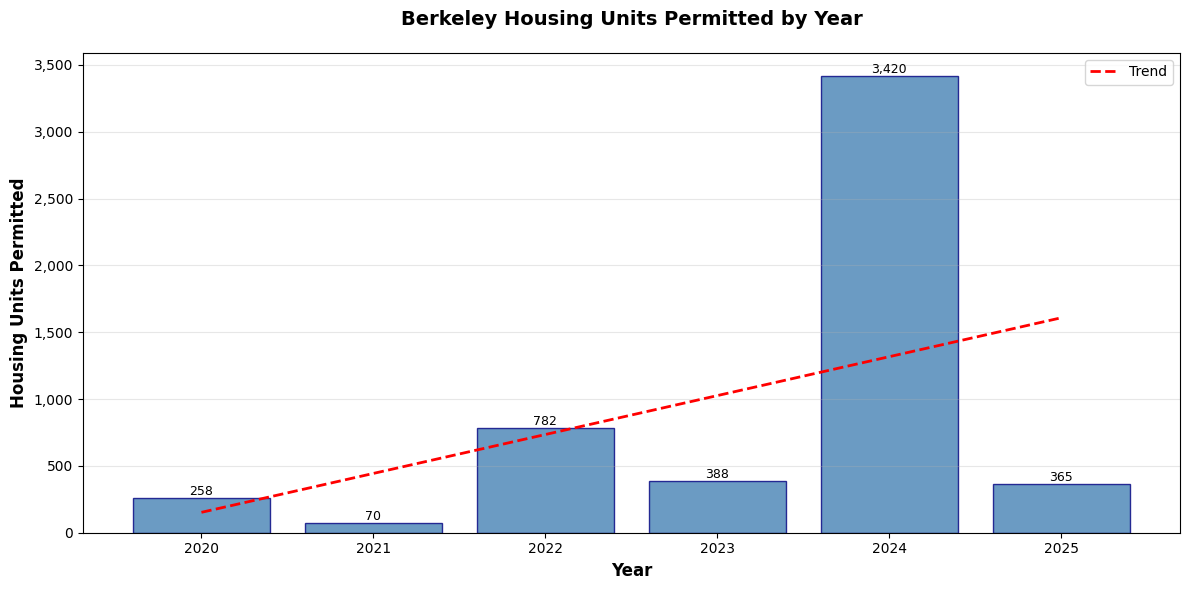

In [17]:
# Visualization 1 - Units Permitted Over Time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Annual units
annual_units = df.groupby('year')['net_units'].sum().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax.bar(annual_units.index, annual_units.values, color='steelblue', alpha=0.8, edgecolor='navy')

# Add trend line
z = np.polyfit(annual_units.index, annual_units.values, 1)
p = np.poly1d(z)
ax.plot(annual_units.index, p(annual_units.index), "r--", linewidth=2, label='Trend')

# Formatting
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Housing Units Permitted', fontsize=12, fontweight='bold')
ax.set_title('Berkeley Housing Units Permitted by Year', fontsize=14, fontweight='bold', pad=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save
plt.savefig(f'{outputs_dir}/units_by_year.png', dpi=300, bbox_inches='tight')
print(f'✅ Saved: {outputs_dir}/units_by_year.png')

plt.show()


✅ Saved: /Users/johngage/berkeley-data/outputs/projects_and_units_by_year.png


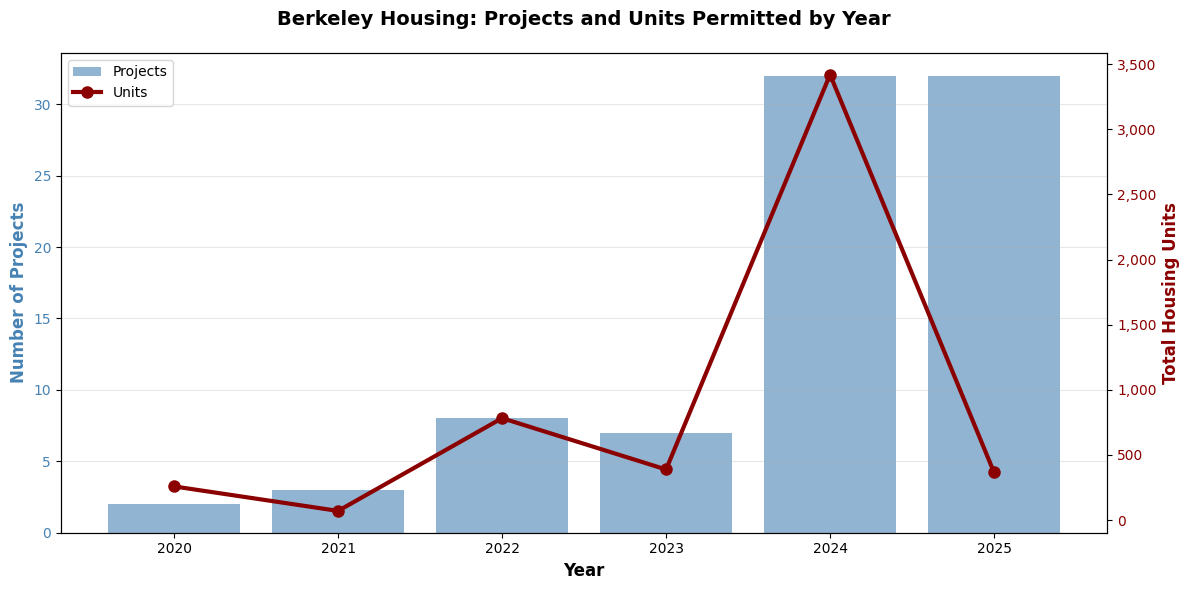

In [18]:
# Visualization 2 - Projects vs Units Over Time

annual_stats = df.groupby('year').agg({
    'address_display': 'count',
    'net_units': 'sum'
}).rename(columns={'address_display': 'projects'})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Projects (bars)
color1 = 'steelblue'
ax1.bar(annual_stats.index, annual_stats['projects'], color=color1, alpha=0.6, label='Projects')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Projects', color=color1, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color1)

# Units (line)
ax2 = ax1.twinx()
color2 = 'darkred'
ax2.plot(annual_stats.index, annual_stats['net_units'], color=color2, marker='o', 
         linewidth=3, markersize=8, label='Units')
ax2.set_ylabel('Total Housing Units', color=color2, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Title and grid
ax1.set_title('Berkeley Housing: Projects and Units Permitted by Year', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()

# Save
plt.savefig(f'{outputs_dir}/projects_and_units_by_year.png', dpi=300, bbox_inches='tight')
print(f'✅ Saved: {outputs_dir}/projects_and_units_by_year.png')

plt.show()


✅ Saved: /Users/johngage/berkeley-data/outputs/cumulative_units.png


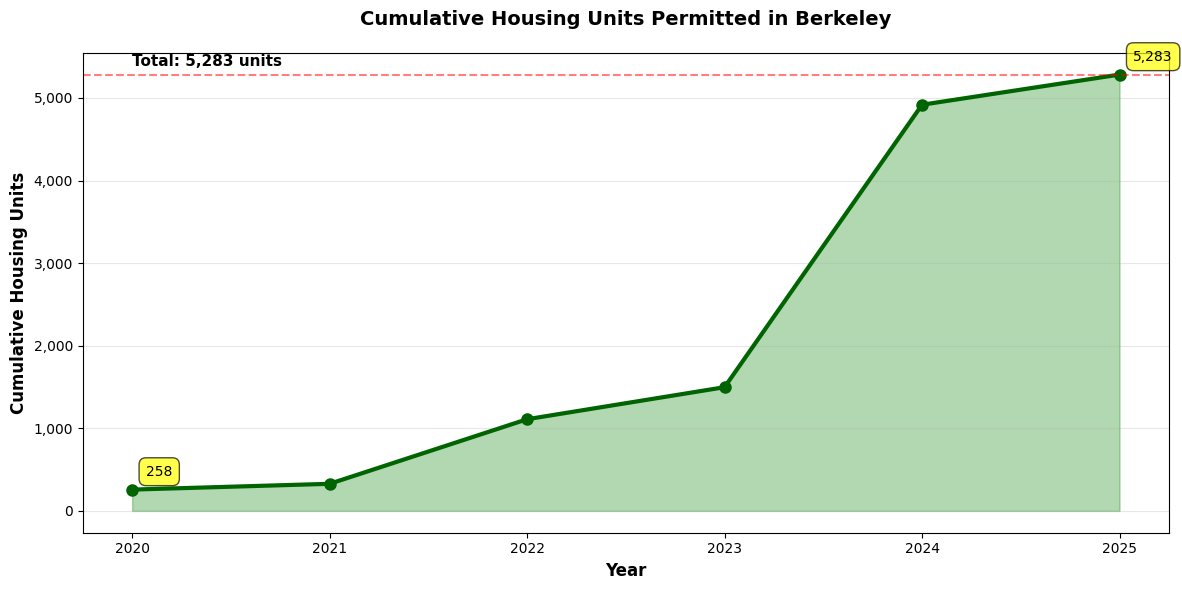

In [19]:
# Visualization 3 - Cumulative Units Growth

cumulative_units = df.groupby('year')['net_units'].sum().cumsum()

fig, ax = plt.subplots(figsize=(12, 6))

# Area chart
ax.fill_between(cumulative_units.index, 0, cumulative_units.values, 
                alpha=0.3, color='green')
ax.plot(cumulative_units.index, cumulative_units.values, 
        color='darkgreen', linewidth=3, marker='o', markersize=8)

# Formatting
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Housing Units', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Housing Units Permitted in Berkeley', 
             fontsize=14, fontweight='bold', pad=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax.grid(axis='y', alpha=0.3)

# Add milestone markers
final_total = cumulative_units.iloc[-1]
ax.axhline(y=final_total, color='red', linestyle='--', alpha=0.5)
ax.text(cumulative_units.index[0], final_total * 1.02, 
        f'Total: {int(final_total):,} units', fontsize=11, fontweight='bold')

# Add value labels at key years
for year in [cumulative_units.index[0], cumulative_units.index[-1]]:
    value = cumulative_units[year]
    ax.annotate(f'{int(value):,}', 
                xy=(year, value), 
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()

# Save
plt.savefig(f'{outputs_dir}/cumulative_units.png', dpi=300, bbox_inches='tight')
print(f'✅ Saved: {outputs_dir}/cumulative_units.png')

plt.show()


## 6. Export Summary Report

In [20]:
print('📄 Generating summary report...')

# Create summary report
report = f'''# Berkeley Housing Development Summary Report 2026 Jan 3

Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Overview

- **Total Projects:** {len(df)}
- **Total Housing Units:** {df["net_units"].sum():,.0f}
- **Date Range:** {df["year"].min():.0f} - {df["year"].max():.0f}
- **Geocoding Success:** {df["latitude"].notna().sum()}/{len(df)} ({df["latitude"].notna().sum()/len(df)*100:.1f}%)

## Projects by Year

{by_year.to_markdown()}

## Projects by Size

{by_size.to_markdown()}

## Top Streets

{top_streets.head(10).to_markdown()}

## Data Files

- Projects CSV: `housing_projects_final_complete.csv`
- Database: `berkeley_housing_analysis.db`
- Interactive Map: `outputs/berkeley_housing_map.html`

## Notes

- All coordinates validated within Berkeley city bounds
- Data sourced from Berkeley Planning Department permits
- Geocoded using Alameda County GIS address points
'''

report_path = f'{outputs_dir}/ANALYSIS_REPORT.md'
with open(report_path, 'w') as f:
    f.write(report)

print(f'✅ Report saved to: {report_path}')
print('\n' + '='*70)
print('\n🎉 ANALYSIS COMPLETE!')
print('\nCreated files:')
print(f'  • {map_path}')
print(f'  • {db_path}')
print(f'  • {report_path}')

📄 Generating summary report...
✅ Report saved to: /Users/johngage/berkeley-data/outputs/ANALYSIS_REPORT.md


🎉 ANALYSIS COMPLETE!

Created files:
  • /Users/johngage/berkeley-data/outputs/berkeley_housing_map.html
  • /Users/johngage/berkeley-data/berkeley_housing_analysis.db
  • /Users/johngage/berkeley-data/outputs/ANALYSIS_REPORT.md


In [21]:
!ls

00_test.ipynb         02_geocoding.ipynb
01_data_import.ipynb  MASTER_ANALYSIS.ipynb


In [22]:
!cd ..; cat ANALYSIS_REPORT.md

cat: ANALYSIS_REPORT.md: No such file or directory


In [23]:
!ls

00_test.ipynb         02_geocoding.ipynb
01_data_import.ipynb  MASTER_ANALYSIS.ipynb


In [24]:
!cd ..;ls

_Receipt_Custom_2017_20251216_122136.pdf
alameda_address_lookup_normalized.csv
alameda_lookup_complete.csv
alameda_lookup_corrected.csv
berkeley_address_points_corrected.csv
berkeley_address_points_fixed.csv
berkeley_address_points.csv
berkeley_addresses_with_fields.csv
berkeley_data
berkeley_data.db
berkeley_housing_analysis.db
berkeley_housing_map_metadata.json
berkeley_housing_map.db
berkeley_open_data_pipeline.ipynb
berkeley_parcels.csv
berkeley.db
business_corridors.db
Business_Licenses_20251113 (1).csv
Business_Licenses_20251113.csv
Business_Licenses_20251114.csv
business_licenses_20251115.csv
business_licenses_20251115.json
business_Licenses.csv
config
convert_all_arcgis.py
convert_boundaries.py
corridor_boundaries.csv
corridor_boundaries.json
corridor_far.csv
corridor_far.json
corridor_ownership_fixed.json
corridor_ownership.csv
corridor_ownership.json
corridor_parcels.geojson
corridor_parcels.json
datasette-vercel
github-pages
housing_pipeline_by_address.png
housing_pipeline_t

In [25]:
!pwd

/Users/johngage/berkeley-data/notebooks


In [26]:
! cat ../ANAL*

zsh:1: no matches found: ../ANAL*


In [27]:
! cat ../ANALYSIS_REPORT.md

cat: ../ANALYSIS_REPORT.md: No such file or directory


In [28]:
!cd ..;pwd


/Users/johngage/berkeley-data


In [29]:
file ANALYSIS_REPORT.md

SyntaxError: invalid syntax (1851873042.py, line 1)

In [30]:
!ls ANALYSIS_REPORT.md

ls: ANALYSIS_REPORT.md: No such file or directory


In [31]:
!cd outputs

zsh:cd:1: no such file or directory: outputs


In [32]:
!ls


00_test.ipynb         02_geocoding.ipynb
01_data_import.ipynb  MASTER_ANALYSIS.ipynb


In [33]:
! cat /Users/johngage/berkeley-data/outputs/ANALYSIS_REPORT.md

# Berkeley Housing Development Summary Report 2026 Jan 3

Generated: 2026-01-05 12:39:05

## Overview

- **Total Projects:** 84
- **Total Housing Units:** 5,283
- **Date Range:** 2020 - 2025
- **Geocoding Success:** 84/84 (100.0%)

## Projects by Year

|   year |   num_projects |   total_units |
|-------:|---------------:|--------------:|
|   2020 |              2 |           258 |
|   2021 |              3 |            70 |
|   2022 |              8 |           782 |
|   2023 |              7 |           388 |
|   2024 |             32 |          3420 |
|   2025 |             32 |           365 |

## Projects by Size

| size_category        |   num_projects |   total_units |
|:---------------------|---------------:|--------------:|
| Small (<20)          |             42 |           173 |
| Small-Medium (20-49) |              6 |           213 |
| Medium (50-99)       |             15 |          1059 |
| Large (100-199)      |              8 |          1085 |
| Very Large (200+)    | 